<a href="https://colab.research.google.com/github/AlvaroUriel/idal_ia3/blob/main/04_ejercicio_series_temporales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#CA0032"><h1 align="left">**Redes Conv1D**</h1></font>

<font color="#6E6E6E"><h1 align="left">**Ejercicio de predicción de series temporales**</h1></font>

<h2 align="left">Manuel Sánchez-Montañés</h2>

<font color="#6E6E6E"><h2 align="left">manuel.smontanes@gmail.com</h2></font>

Librería data augmentation en series temporales:

https://github.com/uchidalab/time_series_augmentation

https://github.com/uchidalab/time_series_augmentation/blob/master/docs/AugmentationMethods.md

Notebook con ejemplos:
https://github.com/uchidalab/time_series_augmentation/blob/master/example.ipynb

## **Ejercicio:**

El objetivo es **adaptar el notebook** para construir un modelo que prediga las ventas de una tienda. El score será la media del R2 (coeficiente de determinación).

Las columnas del dataset son:

* **Store**: ID de la tienda
* **DayOfWeek**: indica si es lunes, martes, miércoles etc.
* **Date**
* **Sales**: ventas (en euros). Es la variable endógena (a predecir)
* **Customers**: número de clientes que realizan compras
* **Open**: 1 si abre la tienda, 0 si no
* **Promo**: 1 si hay promoción especial en esa tienda, 0 si no
* **SchoolHoliday**: 1 si es festivo escolar, 0 si no
* **Columnas StateHoliday**: indican el tipo de festividad estatal que hay ese día en caso de que la hubiera

In [1]:
COLAB = True

In [2]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='162oyA0BcewOgzcLeIwX_jN9VIu5ZOjhE',
                                        dest_path='./ejercicio_datos_diarios_tienda1.csv')
    gdd.download_file_from_google_drive(file_id='1HwxzlB3Ovl34GgQBgyZoW6gbb0Rs7E2E',
                                        dest_path='./ejercicio_datos_diarios_tienda2.csv')
    gdd.download_file_from_google_drive(file_id='12-N_wA3ZU5T3U64XnY0EIImxE3FkTgv6',
                                        dest_path='./my_utils_series_temporales.py')
    !pip install h5py==2.10.0
    # https://github.com/uchidalab/time_series_augmentation
    # https://github.com/uchidalab/time_series_augmentation/blob/master/example.ipynb

    !pip install gitdir
    !gitdir https://github.com/uchidalab/time_series_augmentation/tree/master/utils

     |████████████████████████████████| 2.9 MB 13.9 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Created wheel for gitdir: filename=gitdir-1.2.5-py3-none-any.whl size=5653 sha256=b7a902e90d8e411e03c10c11ab586591e7ee0095b6015eea1ac32ea01a7b7a43
  Stored in directory: /root/.cache/pip/wheels/76/e5/f1/8738f8701ec0cc0b08553b29e63a99a9687f4339e9de5d5c57
Successfully built gitdir
Downloaded: augmentation.py
Downloaded: datasets.py
Downloaded: dtw.py
Downloaded: helper.py
Downloaded: input_data.py
Downloaded: models.py
Downloaded: nemenyi.py
Downloaded: prototype_selection.py
✔ Download complete


In [3]:
!ls utils

augmentation.py  dtw.py     input_data.py  nemenyi.py
datasets.py	 helper.py  models.py	   prototype_selection.py


In [4]:
import utils.augmentation as aug

## <font color="#CA3532"> **1. Importar librerías**

In [5]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

## <font color="#CA3532"> **2. Carga de datos**

In [6]:
!ls

ejercicio_datos_diarios_tienda1.csv  my_utils_series_temporales.py  utils
ejercicio_datos_diarios_tienda2.csv  sample_data


In [7]:
data = pd.read_csv('ejercicio_datos_diarios_tienda1.csv')
#data = pd.read_csv('ejercicio_datos_diarios_tienda2.csv')
data.head(20)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,6,2,2013-01-01,0.0,0.0,0,0,1,0,1,0,0
1,6,3,2013-01-02,6089.0,781.0,1,0,1,1,0,0,0
2,6,4,2013-01-03,5398.0,689.0,1,0,0,1,0,0,0
3,6,5,2013-01-04,6092.0,724.0,1,0,0,1,0,0,0
4,6,6,2013-01-05,3872.0,467.0,1,0,0,1,0,0,0
5,6,7,2013-01-06,0.0,0.0,0,0,0,1,0,0,0
6,6,1,2013-01-07,8591.0,947.0,1,1,0,1,0,0,0
7,6,2,2013-01-08,7099.0,774.0,1,1,0,1,0,0,0
8,6,3,2013-01-09,6749.0,834.0,1,1,0,1,0,0,0
9,6,4,2013-01-10,6282.0,737.0,1,1,0,1,0,0,0


In [8]:
!ls -la

total 104
drwxr-xr-x 1 root root  4096 Dec 18 12:13 .
drwxr-xr-x 1 root root  4096 Dec 18 12:11 ..
drwxr-xr-x 4 root root  4096 Dec  3 14:33 .config
-rw-r--r-- 1 root root 36366 Dec 18 12:13 ejercicio_datos_diarios_tienda1.csv
-rw-r--r-- 1 root root 38421 Dec 18 12:13 ejercicio_datos_diarios_tienda2.csv
-rw-r--r-- 1 root root  4167 Dec 18 12:13 my_utils_series_temporales.py
drwxr-xr-x 1 root root  4096 Dec  3 14:33 sample_data
drwxr-xr-x 3 root root  4096 Dec 18 12:13 utils


In [9]:
data.shape

(881, 12)

## <font color="#CA3532"> **3. Preprocesado inicial y visualización de datos**

In [10]:
type(data['Date'][0])

str

In [11]:
# La fecha es un string, la pasamos a formato fecha de pandas:
data['Date'] = pd.to_datetime(data['Date'])
type(data['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [12]:
data['Date']

0     2013-01-01
1     2013-01-02
2     2013-01-03
3     2013-01-04
4     2013-01-05
         ...    
876   2015-05-27
877   2015-05-28
878   2015-05-29
879   2015-05-30
880   2015-05-31
Name: Date, Length: 881, dtype: datetime64[ns]

In [13]:
data["Date"][880].month

5

In [14]:
fechas      = data['Date'].values
customers   = data['Customers'].values

# a incluir en el modelo:
target      = data['Sales'].values # variable endógena
mes         = [x.month for x in data['Date']]
festivo1    = data['SchoolHoliday'].values
festivo2    = data['StateHoliday_0'].values
festivo3    = data['StateHoliday_a'].values
festivo4    = data['StateHoliday_b'].values
festivo5    = data['StateHoliday_c'].values
open_       = data['Open'].values
promo       = data['Promo'].values
day_of_week = data['DayOfWeek'].values

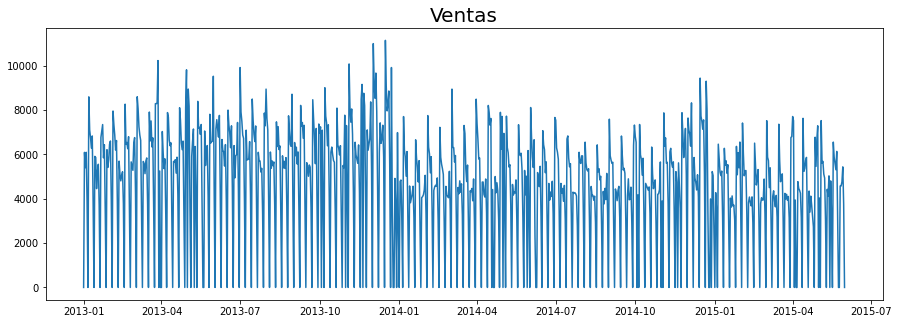

In [15]:
plt.figure(figsize=(15,5))
plt.plot(fechas, target)
plt.title('Ventas',
          fontsize=20);

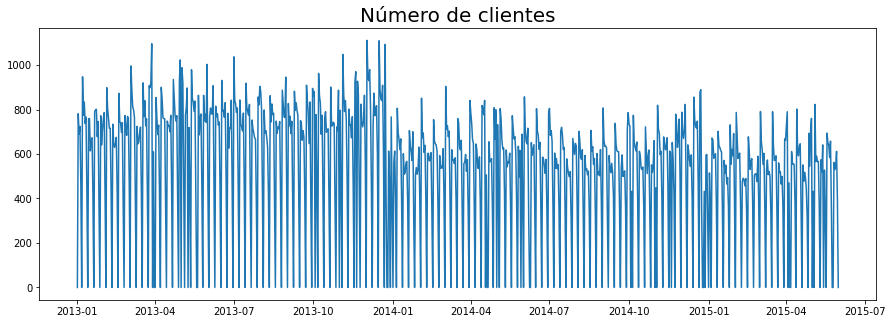

In [16]:
plt.figure(figsize=(15,5))
plt.plot(fechas, customers)
plt.title('Número de clientes', fontsize=20);

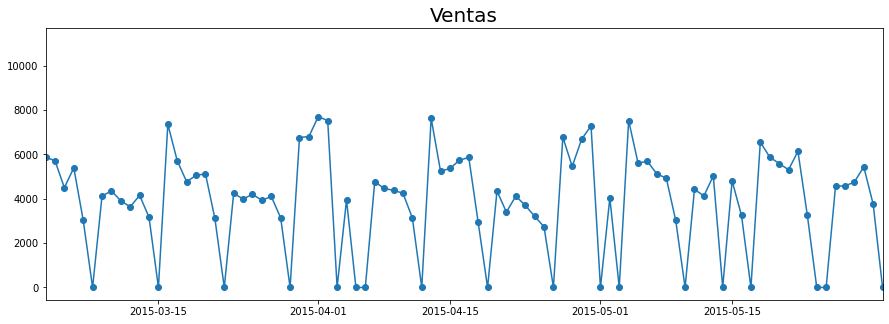

In [17]:
plt.figure(figsize=(15,5))
plt.plot(fechas, target, 'o-')
plt.title('Ventas', fontsize=20)
plt.xlim([fechas[-90],fechas[-1]]);

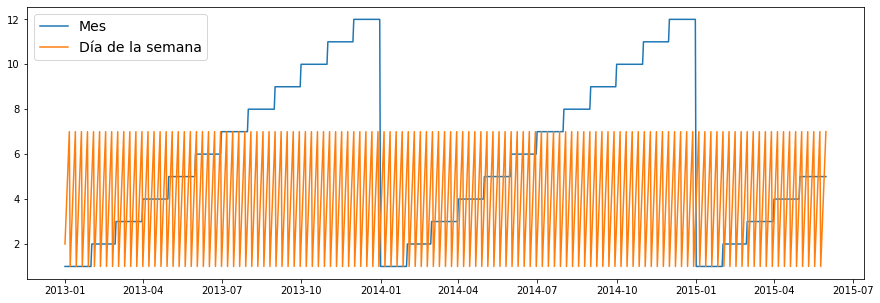

In [18]:
plt.figure(figsize=(15,5))
plt.plot(fechas, mes, label='Mes')
plt.plot(fechas, day_of_week, label='Día de la semana')
plt.legend(fontsize=14);

## <font color="#CA3532"> **4. Transformación de la variable a predecir**

---


In [25]:
# Transformación de escala (ajustar el factor en función del problema)
def transform(x):
    return x/8000
def inverse_transform(x_escalado):
    return x_escalado*8000

In [26]:
transform(np.array([1,2,3]))

array([0.000125, 0.00025 , 0.000375])

## <font color="#CA3532"> **5. Enventanado de datos**

In [27]:
from my_utils_series_temporales import NAN, int2dummy, enventanar, info_enventanado

In [30]:
# en int2dummy el máximo marcado como entrada es un valor legal
one_hot_mes = int2dummy(mes, 1, 12)
one_hot_mes

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
one_hot_day_of_week = int2dummy(day_of_week, 1, 7)
one_hot_day_of_week

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [39]:
print(one_hot_day_of_week.shape, one_hot_mes.shape)

(881, 7) (881, 12)


In [40]:
target_transf = transform(target)

series = [target_transf, festivo1]
se_saben_antes = [False, True]
nombres_series = ["target_transf", "festivo1"]

# Variables calendario sobre las que hemos hecho one-hot encoding
for i in range(one_hot_mes.shape[1]):
    series.append(one_hot_mes[:,i])
    nombres_series.append("mes"+str(i+1))
    se_saben_antes.append(True)

for i in range(one_hot_day_of_week.shape[1]):
    series.append(one_hot_day_of_week[:,i])
    nombres_series.append("day"+str(i+1))
    se_saben_antes.append(True)

In [41]:
print(np.shape(series))
print(np.shape(se_saben_antes))

(21, 881)
(21,)


In [42]:
lookback = 5 # lookback es otro sinónimo de W_in

# target=0 en siguiente línea quiere decir cuál es el índice del target en objeto "series":
X, y = enventanar(series, target=0, se_saben_antes=se_saben_antes,
                  W_in=lookback)

print(X.shape, np.shape(y))

(881, 5, 21) (881,)


In [ ]:
info_enventanado(X[:10],y[:10],
                 nombres_series=nombres_series,
                 nombre_target="target",
                 tiempos=fechas)

In [44]:
print(X.shape)
print(np.shape(target))

(881, 5, 21)
(881,)



## <font color="#CA3532"> **6. Separación training-test**

In [48]:
train_perc  = .8
punto_corte = int(len(X)*train_perc)

In [50]:
X_train      = X[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
y_train      = y[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
target_train = target[lookback:punto_corte] # elimino los lookback primeros al tener NANs
fechas_train = fechas[lookback:punto_corte] # elimino los lookback primeros al tener NANs

X_test       = X[punto_corte:]
y_test       = y[punto_corte:]
target_test  = target[punto_corte:]
fechas_test  = fechas[punto_corte:]

print(np.shape(target_train))
print(np.shape(target_test))

(699,)
(177,)


In [51]:
print(X_train.shape, y_train.shape)

(699, 5, 21) (699,)


## <font color="#CA3532"> **7. Construcción del modelo con Keras**

In [53]:
loss = 'mean_squared_error'

#optimizer = "adam"
optimizer="rmsprop"
#optimizer=Adam(learning_rate=0.01), # más rápido

model = Sequential()
#model.add(Dense(10, input_shape=(lookback, X_train.shape[-1])))
model.add(Conv1D(4, kernel_size=3, activation="relu",
                 input_shape=(lookback, X_train.shape[-1])
                 ))
model.add(Conv1D(4, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(1, # kernel_regularizer='l1'
               )
         )
model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

import keras.backend as K
print(K.get_value(model.optimizer.lr))

0.001


In [55]:
model.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 3, 4)              256       
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 4)              52        
                                                                 
 flatten_1 (Flatten)         (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 8)                 40        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 357
Trainable params: 357
Non-trainable params: 0
_________________________________________________________________


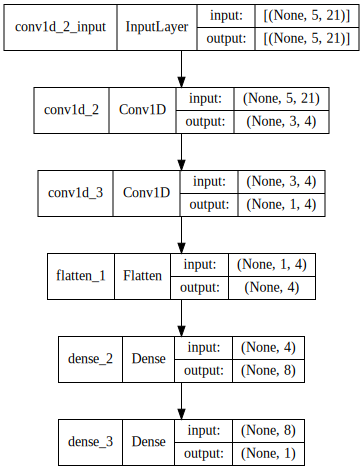

In [57]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [58]:
def grafica_entrenamiento(tr_mse, val_mse):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_mse)), tr_mse)
    plt.plot(1+np.arange(len(val_mse)), val_mse)
    plt.title('mse del modelo', fontsize=18)
    plt.xlabel('epoca', fontsize=18)
    plt.ylabel('mse', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()


Epoch 00001: val_mse improved from inf to 0.18692, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.18692 to 0.14051, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.14051 to 0.11516, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.11516 to 0.10052, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.10052 to 0.09117, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.09117 to 0.08413, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.08413 to 0.07742, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.07742 to 0.07203, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.07203 to 0.06717, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.06717 to 0.06582, saving model to model_current_best.h5

Epoch 00001: val_mse improved from 0.06582 to 0.06178, saving m

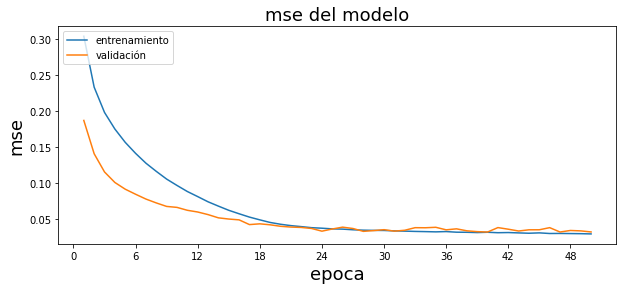


Epoch 00001: val_mse improved from 0.03149 to 0.03008, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.03008

Epoch 00001: val_mse did not improve from 0.03008

Epoch 00001: val_mse did not improve from 0.03008

Epoch 00001: val_mse did not improve from 0.03008

Epoch 00001: val_mse did not improve from 0.03008

Epoch 00001: val_mse did not improve from 0.03008

Epoch 00001: val_mse did not improve from 0.03008

Epoch 00001: val_mse did not improve from 0.03008

Epoch 00001: val_mse did not improve from 0.03008

Epoch 00001: val_mse did not improve from 0.03008

Epoch 00001: val_mse did not improve from 0.03008

Epoch 00001: val_mse did not improve from 0.03008

Epoch 00001: val_mse did not improve from 0.03008

Epoch 00001: val_mse improved from 0.03008 to 0.02908, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.02908

Epoch 00001: val_mse did not improve from 0.02908

Epoch 00001: val_mse did not improve from 0.02

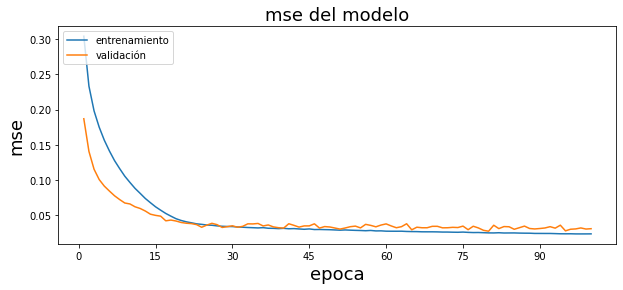


Epoch 00001: val_mse did not improve from 0.02706

Epoch 00001: val_mse did not improve from 0.02706

Epoch 00001: val_mse did not improve from 0.02706

Epoch 00001: val_mse did not improve from 0.02706

Epoch 00001: val_mse did not improve from 0.02706

Epoch 00001: val_mse did not improve from 0.02706

Epoch 00001: val_mse did not improve from 0.02706

Epoch 00001: val_mse did not improve from 0.02706

Epoch 00001: val_mse did not improve from 0.02706

Epoch 00001: val_mse did not improve from 0.02706

Epoch 00001: val_mse did not improve from 0.02706

Epoch 00001: val_mse did not improve from 0.02706

Epoch 00001: val_mse did not improve from 0.02706

Epoch 00001: val_mse did not improve from 0.02706

Epoch 00001: val_mse did not improve from 0.02706

Epoch 00001: val_mse did not improve from 0.02706

Epoch 00001: val_mse did not improve from 0.02706

Epoch 00001: val_mse did not improve from 0.02706

Epoch 00001: val_mse did not improve from 0.02706

Epoch 00001: val_mse did not i

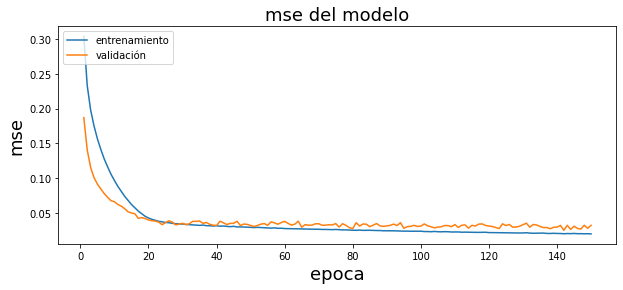


Epoch 00001: val_mse did not improve from 0.02453

Epoch 00001: val_mse did not improve from 0.02453

Epoch 00001: val_mse did not improve from 0.02453

Epoch 00001: val_mse did not improve from 0.02453

Epoch 00001: val_mse did not improve from 0.02453

Epoch 00001: val_mse did not improve from 0.02453

Epoch 00001: val_mse did not improve from 0.02453

Epoch 00001: val_mse did not improve from 0.02453

Epoch 00001: val_mse did not improve from 0.02453

Epoch 00001: val_mse did not improve from 0.02453

Epoch 00001: val_mse did not improve from 0.02453

Epoch 00001: val_mse did not improve from 0.02453

Epoch 00001: val_mse did not improve from 0.02453

Epoch 00001: val_mse did not improve from 0.02453

Epoch 00001: val_mse did not improve from 0.02453

Epoch 00001: val_mse did not improve from 0.02453

Epoch 00001: val_mse did not improve from 0.02453

Epoch 00001: val_mse did not improve from 0.02453

Epoch 00001: val_mse did not improve from 0.02453

Epoch 00001: val_mse did not i

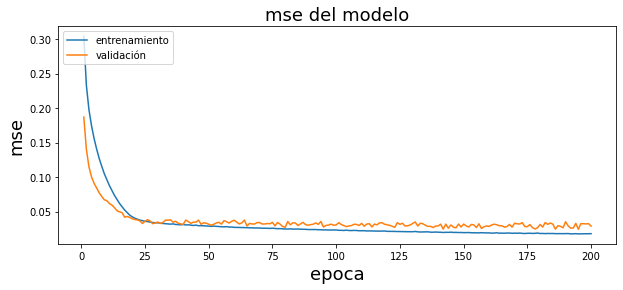


Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not i

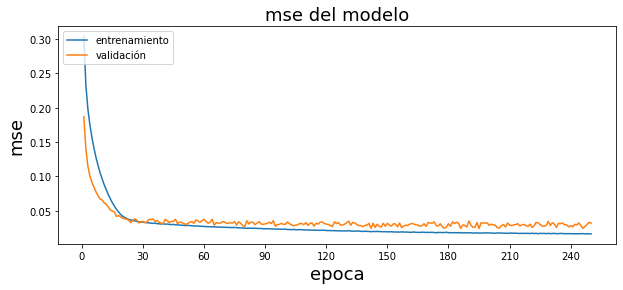


Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse did not improve from 0.02436

Epoch 00001: val_mse improved from 0.02436 to 0.02355, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.02355

Epoch 00001: val_mse did not improve from 0.02355

Epoch 00001: val_mse did not improve from 0.02355

Epoch 00001: val_mse did not improve from 0.02355

Epoch 00001: val_mse did not improve from 0.02355

Epoch 00001: val_mse did not improve from 0.02355

Epoch 00001: val_mse did not improve from 0.02355

Epoch 00001: val_mse did not improve from 0.02355

Epoch 00001: val_mse did not improve f

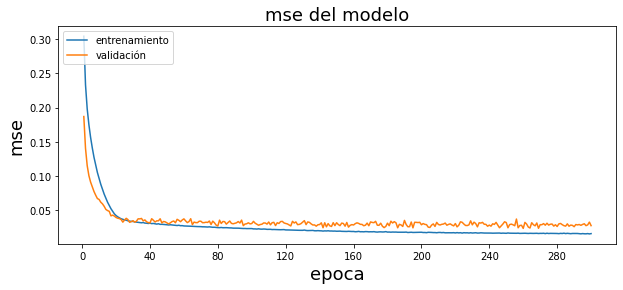


Epoch 00001: val_mse did not improve from 0.02355

Epoch 00001: val_mse did not improve from 0.02355

Epoch 00001: val_mse did not improve from 0.02355

Epoch 00001: val_mse did not improve from 0.02355

Epoch 00001: val_mse did not improve from 0.02355

Epoch 00001: val_mse improved from 0.02355 to 0.02159, saving model to model_current_best.h5

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve f

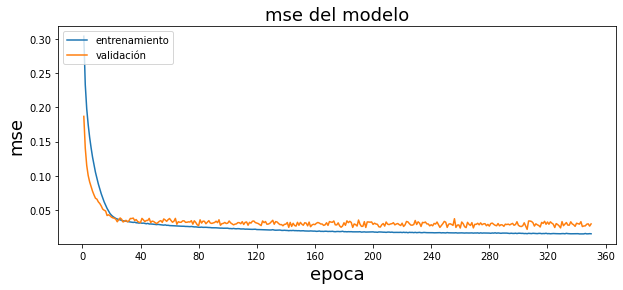


Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not improve from 0.02159

Epoch 00001: val_mse did not i

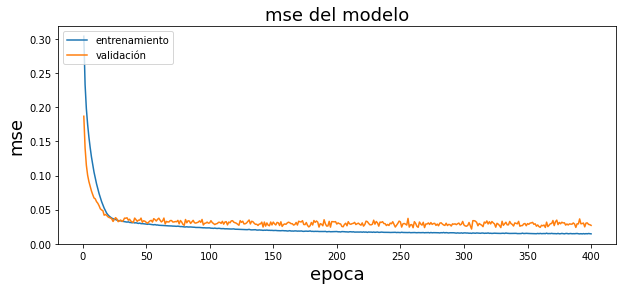

In [59]:
epochs = 400
batch_size = 64
Nval = 200
control_sobreajuste_val = True

if not control_sobreajuste_val:
    history = model.fit(X_train, y_train, epochs=epochs,
                        batch_size=batch_size, verbose=2)
else:    
    acum_tr_mse = []
    acum_val_mse = []
    modelpath="model_current_best.h5"
    checkpoint = ModelCheckpoint(modelpath, monitor='val_mse', verbose=2, # val_mean_squared_error
                                 save_best_only=True,
                                 mode='min') # graba sólo los que mejoran en validación

    callbacks_list = [checkpoint]
    
    for e in range(epochs):
        #aux = aug.scaling(aug.jitter(X_train[:-Nval])) # data augmentation con jitter
        aux = X_train[:-Nval]
        history = model.fit(aux, y_train[:-Nval],
                            batch_size=batch_size,
                            epochs=1,
                            callbacks=callbacks_list,
                            verbose=0,
                            validation_data=(X_train[-Nval:], y_train[-Nval:]))
        
        acum_tr_mse  += history.history['mse'] # mean_squared_error
        acum_val_mse += history.history['val_mse'] # val_mean_squared_error
        
        if (e+1)%50 == 0:
            grafica_entrenamiento(acum_tr_mse, acum_val_mse)

In [60]:
model = load_model(modelpath) # recupero el mejor modelo en validación

\## <font color="#CA3532"> **8. Chequeo del modelo (predicción a un día)**

In [61]:
y_train_prediction = model.predict(X_train).flatten()
y_test_prediction = model.predict(X_test).flatten()

In [62]:
target_train_pred = inverse_transform(y_train_prediction)
target_test_pred  = inverse_transform(y_test_prediction)

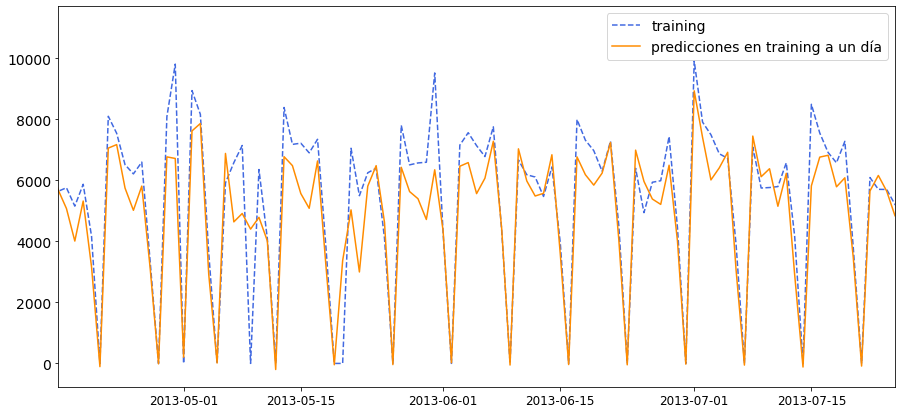

In [63]:
plt.figure(figsize=(15,7))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label="training")
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label="predicciones en training a un día")

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlim([fechas_train[100],fechas_train[200]])
plt.legend(fontsize=14);

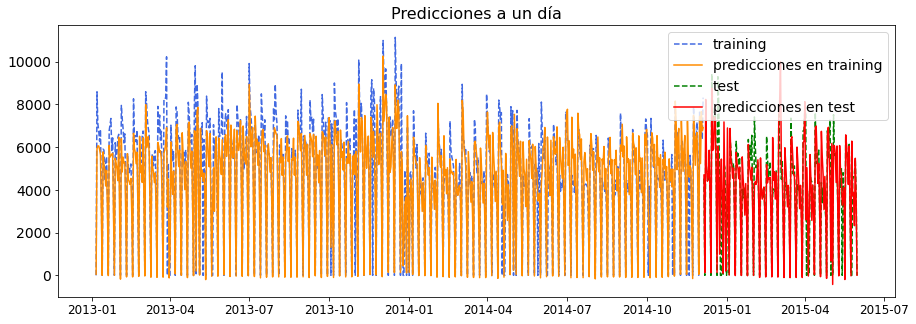

In [64]:
plt.figure(figsize=(15,5))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label='training')
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label='predicciones en training')
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test')
plt.plot(fechas_test, target_test_pred,    c='red',
         label='predicciones en test')
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.title('Predicciones a un día', fontsize=16)
plt.legend(fontsize=14);

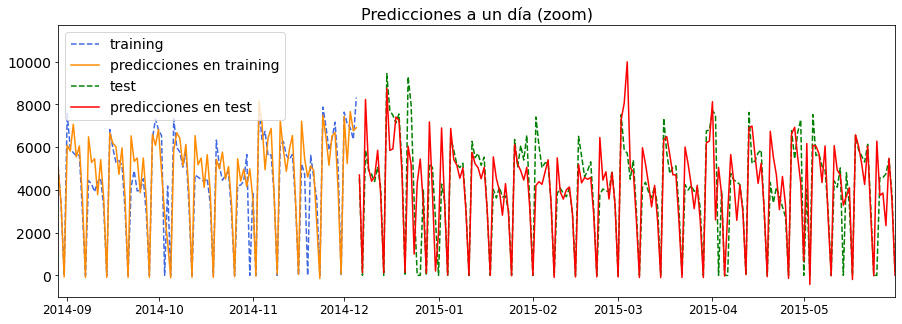

In [65]:
plt.figure(figsize=(15,5))
plt.plot(fechas_train, target_train, '--', c='royalblue',
         label='training')
plt.plot(fechas_train, target_train_pred,  c='darkorange',
         label='predicciones en training')
plt.plot(fechas_test, target_test, '--',   c='green',
         label='test')
plt.plot(fechas_test, target_test_pred,    c='red',
         label='predicciones en test')
plt.title('Predicciones a un día (zoom)', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlim([fechas_train[600],fechas_test[-1]]);

In [66]:
# Modelos de referencia (en orden de complejidad):
# 1- Predecir siempre media (mediana) en training
# 2- Modelo persistente (a 1 día, 7 días etc.)
# 3- SARIMAX


# R2 scores
print("R2 del modelo en training      : ",
      R2_score(target_train[1:], target_train_pred[1:]))
print("R2 del modelo en test          : ",
      R2_score(target_test, target_test_pred))
print("R2 modelo persistente 1 día    : ",
      R2_score(target_test[1:], target_test[:-1]))
print("R2 modelo persistente 1 semana : ",
      R2_score(target_test[7:], target_test[:-7]))
print("R2 modelo persistente 4 semanas: ",
      R2_score(target_test[28:], target_test[:-28]))
print("R2 modelo persistente 1 año: ",
      R2_score(target_train[7*52:], target_train[:-7*52]))

R2 del modelo en training      :  0.8176722187441374
R2 del modelo en test          :  0.627614182714505
R2 modelo persistente 1 día    :  -0.7744426971461007
R2 modelo persistente 1 semana :  0.09031044639919739
R2 modelo persistente 4 semanas:  0.2968352214432024
R2 modelo persistente 1 año:  0.14588794888918843
